In [1]:
import os
import numpy as np
import ssl
import pandas as pd

import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import LSTM, Input, Dense, TimeDistributed, RepeatVector, SimpleRNN
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import Model

### Data load

In [2]:
url = 'https://raw.githubusercontent.com/JunetaeKim/DeepLearningClass/main/Dataset/energydata_complete.csv'
Energy = pd.read_csv(url)
Energy = Energy.drop(columns='date')

#### Data description

#### The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters. Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis (rp5.ru), and merged together with the experimental data sets using the date and time column. 

#####
##### date time year-month-day hour:minute:second
##### Appliances, energy use in Wh
##### lights, energy use of light fixtures in the house in Wh

##### T1, Temperature in kitchen area, in Celsius
##### RH_1, Humidity in kitchen area, in %
##### T2, Temperature in living room area, in Celsius
##### RH_2, Humidity in living room area, in %
##### T3, Temperature in laundry room area
##### RH_3, Humidity in laundry room area, in %
##### T4, Temperature in office room, in Celsius
##### RH_4, Humidity in office room, in %
##### T5, Temperature in bathroom, in Celsius
##### RH_5, Humidity in bathroom, in %
##### T6, Temperature outside the building (north side), in Celsius
##### RH_6, Humidity outside the building (north side), in %
##### T7, Temperature in ironing room , in Celsius
##### RH_7, Humidity in ironing room, in %
##### T8, Temperature in teenager room 2, in Celsius
##### RH_8, Humidity in teenager room 2, in %
##### T9, Temperature in parents room, in Celsius
##### RH_9, Humidity in parents room, in %
##### To, Temperature outside (from Chievres weather station), in Celsius
##### Pressure (from Chievres weather station), in mm Hg
##### RH_out, Humidity outside (from Chievres weather station), in %
##### Wind speed (from Chievres weather station), in m/s
##### Visibility (from Chievres weather station), in km
##### Tdewpoint (from Chievres weather station), Â°C
##### rv1, Random variable 1, nondimensional
##### rv2, Random variable 2, nondimensional
##### Where indicated, hourly data (then interpolated) from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis, rp5.ru. Permission was obtained from Reliable Prognosis for the distribution of the 4.5 months of weather data.

### Data preprocessing 

In [7]:
### Normalization
scaler = MinMaxScaler()
scaler.fit(Energy)
Energy=scaler.transform(Energy)

Energy_T =  np.transpose(Energy, (1,0))
FrameDAta = tf.signal.frame(Energy_T, 24, 6)
FrameDAta = np.transpose(FrameDAta, (1,2,0))

### Data selection for input and output 
InpData = FrameDAta[:,:18, :] # Input features during the previous three hours
TargetData = FrameDAta[:,18:, :2] # Appliances and light usage during the next one hour

In [9]:
InpData.shape

(3286, 18, 28)

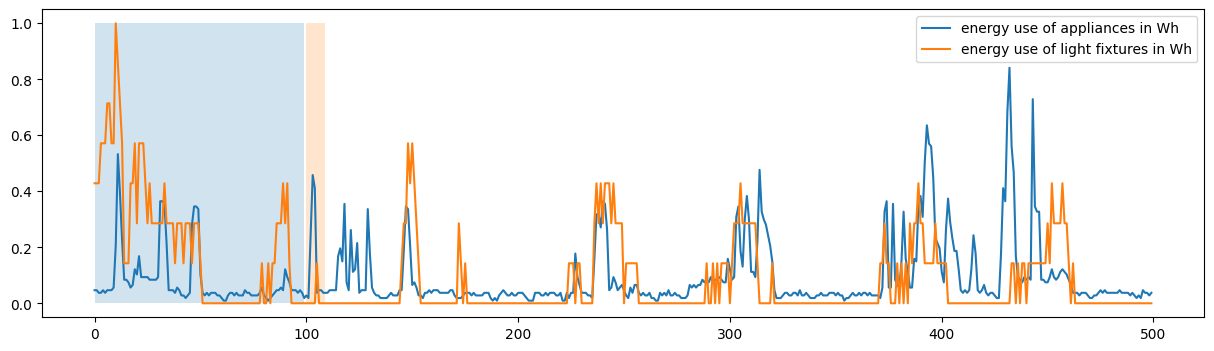

In [8]:
plt.figure(figsize=(15, 4))
plt.plot(Energy[:500, 0:1], label='energy use of appliances in Wh')
plt.plot(Energy[:500, 1:2], label='energy use of light fixtures in Wh')
plt.fill_between(np.arange(500)[:100],1, alpha=0.2) 
plt.fill_between(np.arange(500)[100:100+10],1, alpha=0.2) 

plt.legend()

### Train/Test split

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split( InpData, TargetData, test_size=0.25, random_state=0)

### Model save directory setting

In [11]:
save_path = './Results/'
if not os.path.exists(save_path):
    os.mkdir(save_path)

### Model definition

In [12]:
def ENERGYModel ():
    InpL = Input(shape=(X_train.shape[1], X_train.shape[2]))
    LSTML = LSTM(20, return_sequences=True)(InpL)
    LSTMOut = LSTM(10, return_sequences=False)(LSTML)

    LSTMOut = RepeatVector(6)(LSTMOut)
    Output = TimeDistributed(Dense(10))(LSTMOut)
    Output = LSTM(10, return_sequences=True)(Output)
    Output = Dense(2, activation='sigmoid')(Output)

    return Model(InpL,Output)   
    

In [13]:
### Model checkpoint
ModelSaveSameName = save_path+'ENERGY.hdf5'
ModelSave = ModelCheckpoint(filepath=ModelSaveSameName, monitor='val_loss', verbose=1, save_best_only=True)

### Model Early stop
EarlyStop = EarlyStopping(monitor='val_loss', patience=100)

ENERGYM = ENERGYModel()
ENERGYM.compile(loss=tf.losses.mse, optimizer='adam')
ENERGYMHist = ENERGYM.fit(X_train, Y_train, validation_data=(X_test,Y_test), epochs=1000, batch_size=100,  verbose=1, callbacks=[ModelSave, EarlyStop])

Epoch 1/1000
25/25 [==============================] - 7s 88ms/step - loss: 0.1242 - val_loss: 0.0384

Epoch 00001: val_loss improved from inf to 0.03836, saving model to ./Results\ENERGY.hdf5
Epoch 2/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.0296 - val_loss: 0.0179

Epoch 00002: val_loss improved from 0.03836 to 0.01795, saving model to ./Results\ENERGY.hdf5
Epoch 3/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0154 - val_loss: 0.0149

Epoch 00003: val_loss improved from 0.01795 to 0.01486, saving model to ./Results\ENERGY.hdf5
Epoch 4/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.0133 - val_loss: 0.0140

Epoch 00004: val_loss improved from 0.01486 to 0.01397, saving model to ./Results\ENERGY.hdf5
Epoch 5/1000
25/25 [==============================] - 0s 14ms/step - loss: 0.0118 - val_loss: 0.0135

Epoch 00005: val_loss improved from 0.01397 to 0.01353, saving model to ./Results\ENERGY.hdf5
Epoch 6/1000
25/25 [====

### Model weight load and evaluate it

In [14]:
ENERGYM = ENERGYModel()
ENERGYM.compile(loss=tf.losses.mse, optimizer='adam')
print('Before loading weights')
print(ENERGYM.evaluate(X_test,Y_test, batch_size=300 ))
print()

ENERGYM.load_weights(ModelSaveSameName)
print('After loading weights')
print(ENERGYM.evaluate(X_test,Y_test, batch_size=300))

Before loading weights
3/3 [==============================] - 0s 4ms/step - loss: 0.1979
0.1987961083650589

After loading weights
3/3 [==============================] - 0s 4ms/step - loss: 0.0074
0.00744982436299324


### Plot loss graphs

Text(0, 0.5, 'loss')

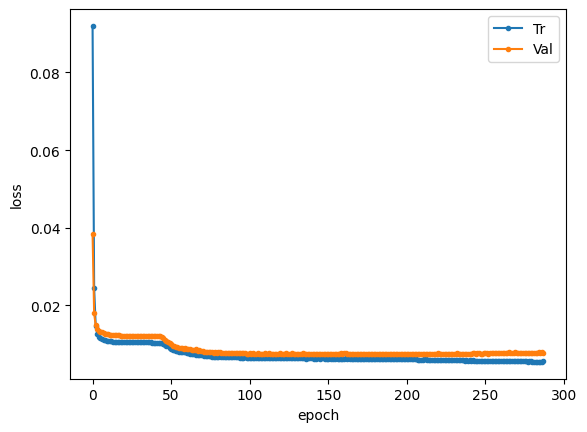

In [15]:
plt.plot(ENERGYMHist.history['loss'], label='Tr', marker='.')
plt.plot(ENERGYMHist.history['val_loss'], label='Val', marker='.')
plt.legend() 
plt.xlabel('epoch')
plt.ylabel('loss')

### Prediction example
#### Energy use of appliances in Wh

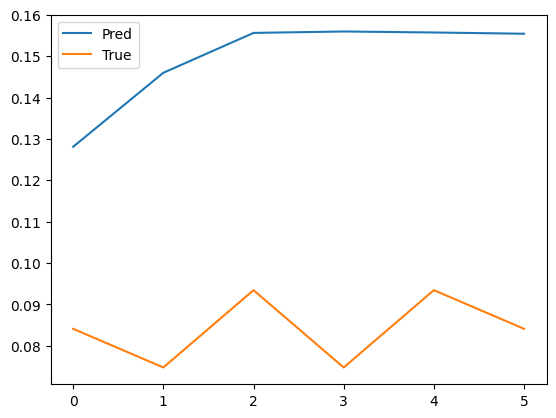

In [16]:
Pred = ENERGYM.predict(X_test, batch_size=300 )

idx = 0
plt.plot(Pred[idx, :, 0], label='Pred')
plt.plot(Y_test[idx, :, 0], label='True')
plt.legend()

### Prediction example
#### Energy use of light fixtures in Wh

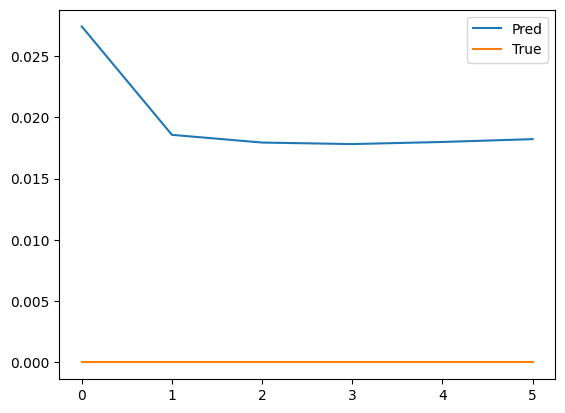

In [17]:
idx = 0
plt.plot(Pred[idx, :, 1], label='Pred')
plt.plot(Y_test[idx, :, 1], label='True')
plt.legend()